# autoMI with markov / PCFG
This notebooks combines the PCFG and Markov models to create a PCFG with Markov endpoints. One application of this model is language, where phonological organization is thought to be largely Markovian, and syntactic and discourse structure are thought to be hierarchical. 

See
- [Parallels in the sequential organization of birdsong and human speech. T Sainburg, B Thielman, M Thielk, TQ Gentner, (2019) Nature Communications](https://doi.org/10.1038/s41467-019-11605-y)
- [Long-range sequential dependencies precede complex syntactic production in language acquisition. T Sainburg, A Mai, TQ Gentner. Proceedings of the Royal Society B](https://dx.doi.org/10.1098/rspb.2021.2657)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import mlab
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

## Create signal and sample sequences

In [3]:
def gen_balanced_matrix(na=5, ps=[0.7, 0.2, 0.1]):
    """ Generates a balanced matrix in which every state can reach every other state
    for hierarchical and Markov models
    """
    for r in range(1000):
        breakme = False
        probs = np.zeros((na, na))
        for p in ps:
            for i in np.arange(na):
                ixloc = np.where(
                    (probs[i, :] == 0) & (np.sum(probs != p, axis=0) == na)
                )[0]
                if len(ixloc) > 0:
                    probs[i, np.random.permutation(ixloc)[0]] = p
                else:
                    # the initialization didn't work
                    breakme = True
        if breakme:
            continue
        probs = probs / np.sum(probs, axis=0)
        return probs
    return "Generation Failed"

def gen_seq_hierarchical(alphabet, probs, depth, n_subsamples):
    """ generates a sequence via the Lin Tegmark recursive model
    Arguments:
        alphabet {[type]} -- [alphabet of states]
        probs {[type]} -- [probability matrix for recursive subsampling]
        depth {[type]} -- [how many times to recursively subsample]
        n_subsamples {[type]} -- [the number of new elements to recursively replace old elements with]
    
    Returns:
        sequence [type] -- [sequence of elements]
    """
    sequence = np.random.choice(
        alphabet, p=np.sum(probs, axis=1) / np.sum(probs), size=1
    )
    if type(depth) == list:
        depth = np.random.choice(depth)
    depth_list = range(depth)
    for i in depth_list:
        q = np.random.choice(n_subsamples)
        sequence = recursively_subsample_sequence(sequence, probs, q, alphabet)
    return sequence


def subsample_sequence(sequence, probs, q, alphabet):
    """ subsamples a sequence given a probability matrix
    
    given a sequence, resamples each element in that sequences given a probability matrix of sequence element to new elements
    
    Arguments:
        sequence {[type]} -- input sequence
        probs {[type]} -- the probability matrix
        q {[type]} -- the number of items to subsample
    """
    return [
        item
        for sublist in [
            np.random.choice(alphabet, p=probs[:, i], size=q) for i in sequence
        ]
        for item in sublist
    ]

def recursively_subsample_sequence(sequence, probs, q, alphabet):
    """ subsamples a sequence given a probability matrix
    
    given a sequence, resamples each element in that sequences given a probability matrix of sequence element to new elements
    
    Arguments:
        sequence {[type]} -- input sequence
        probs {[type]} -- the probability matrix
        q {[type]} -- the number of items to subsample
    """
    for i in sequence:
        if type(i) == list:
            return [recursively_subsample_sequence(i, probs, q, alphabet) for i in sequence]
        else:
            return [
                item
                for sublist in [
                    [list(np.random.choice(alphabet, p=probs[:, i], size=q))] for i in sequence
                ]
                for item in sublist
            ]
def gen_seq_markov(alphabet, probs, seq_len):
    """ like sample_sequence_MM, but uses a numpy matrix, no start and end states, and a set sequence length
    """
    sequence = list(
        np.random.choice(alphabet, p=np.sum(probs, axis=0) / np.sum(probs), size=1)
    )
    for i in tqdm(range(seq_len), leave=False):
        sequence.append(np.random.choice(alphabet, p=probs[:, sequence[-1]], size=1)[0])
    return sequence

In [4]:
# how many branches to sample in hierarchical
n_subsamples = [2]
# how many subsamples to perform
depth = 12
# alphabet size
a_n = 5
alphabet = np.arange(a_n)
# how many sequences to use
nseq = 1000
print('seq len ',(np.mean(n_subsamples)**depth))

seq len  4096.0


In [5]:
# how many markov items to sample 
markov_seq_len_range = [2,5]
# number of elements in markov alphabet
a_n_markov = 25
markov_alphabet_items = np.arange(a_n_markov)
# the number of sequences can correspond to each hierarchical element
markov_n_seq_per_element = 5

In [6]:
# generate probbility matrix 
probs = gen_balanced_matrix(na=a_n, ps=[.9, .1])

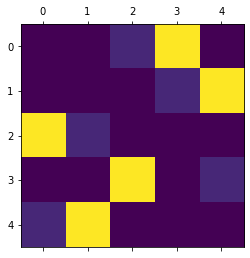

In [7]:
plt.matshow(probs)

In [8]:
# generate markov probabilities
markov_probs = np.random.rand(a_n_markov**2).reshape((a_n_markov, a_n_markov))**2
markov_probs = markov_probs/np.sum(markov_probs, axis = 0)
# test it out...
gen_seq_markov(markov_alphabet_items, markov_probs, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

[8, 6, 3, 8, 8, 8, 8, 17, 1, 15, 22]

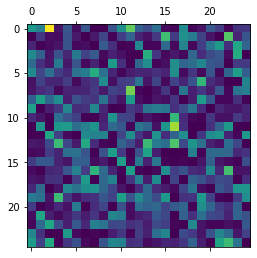

In [9]:
plt.matshow(markov_probs)

In [10]:
# each leaf in the tree grammar should correspond to a markov generated sequence
markov_alphabet = {
    i: [
        gen_seq_markov(
            markov_alphabet_items,
            markov_probs,
            np.random.randint(markov_seq_len_range[0], markov_seq_len_range[1]),
        )
        for j in range(markov_n_seq_per_element)
    ]
    for i in tqdm(markov_alphabet_items)
}
markov_alphabet[alphabet[0]]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[[3, 12, 8, 12],
 [18, 19, 20],
 [15, 13, 6, 5, 3],
 [20, 11, 9, 11],
 [9, 14, 8, 22, 15]]

In [12]:
from joblib import Parallel, delayed

In [13]:
sequences = Parallel(n_jobs = -1)(delayed(gen_seq_hierarchical)(alphabet, probs, depth, n_subsamples=n_subsamples) for seq in tqdm(range(nseq)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
len(sequences), len(sequences[0])

(1000, 1)

In [17]:
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

In [18]:
# flatten sequences from tree structure
flat_sequences = [list(flatten(i)) for i in tqdm(sequences)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
len(flat_sequences[0])

## First, we can look at MI over PCFG sequences without Markov endpoints

In [ ]:
from automutualinformation import sequential_mutual_information as smi

In [21]:
range_ = np.arange(1,100)

In [22]:
(MI, _), (shuff_MI, _) = smi(
    flat_sequences, distances=range_
)

  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   18.1s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   18.6s finished


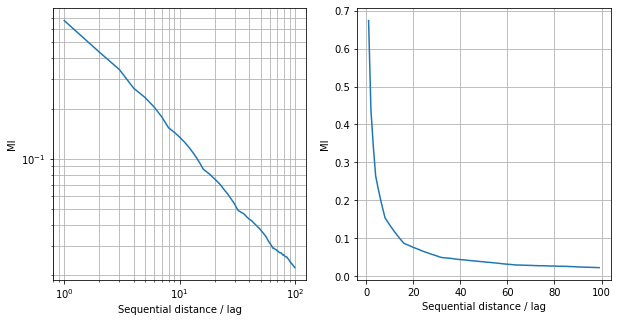

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(range_, MI - shuff_MI)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')

ax = axs[1]
ax.plot(range_, MI - shuff_MI)
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')


## Now, we can look at MI over sequences with Markov endpoints

In [27]:
def replace_markov_alphabet_recursive(sequence, markov_alphabet, markov_n_seq_per_element):
    """ subsamples a sequence given a probability matrix
    
    given a sequence, resamples each element in that sequences given a probability matrix of sequence element to new elements
    
    Arguments:
        sequence {[type]} -- input sequence
        probs {[type]} -- the probability matrix
        q {[type]} -- the number of items to subsample
    """
    for i in sequence:
        if type(i) == list:
            return [replace_markov_alphabet_recursive(i,markov_alphabet, markov_n_seq_per_element) for i in sequence]
        else:
            return markov_alphabet[i][np.random.choice(sequence)]
def replace_markov_alphabet(seq, markov_alphabet,markov_n_seq_per_element):
    return [markov_alphabet[i][np.random.choice(markov_n_seq_per_element)] for i in seq]

In [29]:
# replace each element with Markov sampled sequences
sequences_markov = Parallel(n_jobs = -1)(delayed(replace_markov_alphabet_recursive)(seq, markov_alphabet,markov_n_seq_per_element) for seq in tqdm(sequences))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
flat_sequences_markov = [list(flatten(i)) for i in tqdm(sequences_markov)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
(MI, _), (shuff_MI, _) = smi(
    flat_sequences_markov, distances=range_
)

  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   46.5s finished


  0%|          | 0/99 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   45.9s finished


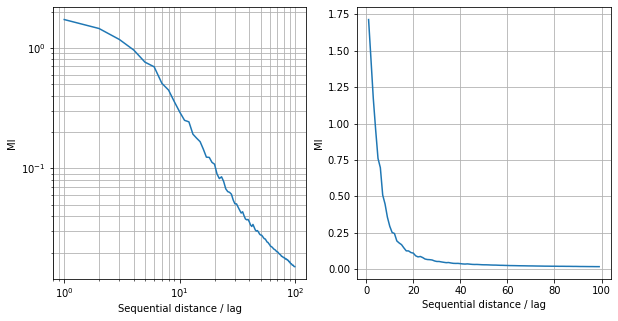

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(range_, MI - shuff_MI)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')

ax = axs[1]
ax.plot(range_, MI - shuff_MI)
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')


### Fitting a decay model

In [38]:
from automutualinformation import fit_model

In [40]:
decay_model, model_y = fit_model(
    distances = range_,
    sig = MI - shuff_MI,
    decay_function = "pow_exp"
)
decay_model

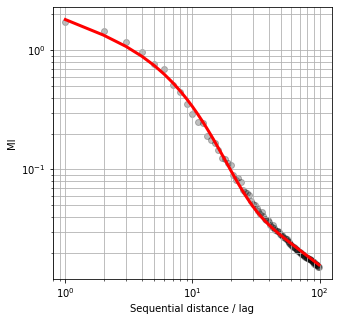

In [41]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.scatter(range_, MI - shuff_MI, color = 'k', alpha = 0.25)

ax.plot(range_, model_y, lw=3, color = 'red')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')